## Modelling the sea using grid-based methods

In [27]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-ladcmp12.log
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https

In [24]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time

import math
import IPython

In [2]:
base_lat = [32, 37]
base_lon = [124, 129]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 30
pivot_time = 5
gridmap_pivot_distance_km = 5

earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490, 
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188, 
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

In [3]:
absolute_distance_pos

[[0, 111.195, 111.195, 111.195, 111.195, 111.195],
 [0, 96.49, 96.49, 91.29, 91.29, 91.29]]

In [4]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(tlat != gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km - tlat
        elif(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lat.append(grid_lat[-1] + dlat)

        if(vlat <= 0):
            break

collection_grid_lat = [(grid_lat[i]-base_lat[0])*(base_lat[1]-grid_lat[-1])/(grid_lat[-1]-base_lat[0]) for i in range(0, len(grid_lat))]
grid_lat = [x+y for x,y in zip(grid_lat, collection_grid_lat)]

for ilon in range(1, len(absolute_distance_pos[1])):
    vlon = absolute_distance_pos[1][ilon]
    while(True):
        tlon = 0
        if(tlon != gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km - tlon
        elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
        else: tlon = vlon # vlon <= gridmap_pivot_distance_km
            
        vlon -= tlon
        dlon = tlon/lon_distance_per_one[(ilon//5)*5]
            
        grid_lon.append(grid_lon[-1] + dlon)
            
        if(vlon <= 0):
            break

collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/(grid_lon[-1]-base_lon[0]) for i in range(0, len(grid_lon))]
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]
        
print('Grid_latitude len: %d'%(len(grid_lat)))
print('Grid_longitude len: %d'%(len(grid_lon)))

Grid_latitude len: 116
Grid_longitude len: 98


In [5]:
def draw_basemap_grid(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor="none", edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

In [6]:
DATA_DIR = "data/AIS/"
skiprow_count = 3

f = open(DATA_DIR+'Dynamic_20200203.csv', 'r', encoding='cp949')
for i in range(0, skiprow_count):
    line = f.readline()
    if not line: break
    print(line)
f.close()

ais = pd.read_csv(DATA_DIR+'Dynamic_20200203.csv',
                  encoding='cp949', sep='\s+|,', engine='python', 
                  skiprows=range(0, skiprow_count),
                  names=['MMSI','일자', '시간', '위도','경도', 'SOG', 'COG', 'Heading'])
print('Data len in AIS:' + str(len(ais)))
ais.drop(ais[(ais['위도'] < base_lat[0]) | (ais['위도'] > base_lat[1]) | (ais['경도'] < base_lon[0]) | (ais['경도'] > base_lon[1])].index, inplace=True)
print('Data len in Range:' + str(len(ais)))

조회 기간 : 2020-02-03 00:00:00 ~ 2020-02-03 23:59:59

조회선박 척수 : 7638

MMSI,일시,위도,경도,SOG,COG,Heading

Data len in AIS:20418467
Data len in Range:12050523


In [7]:
ais.dtypes

MMSI        object
일자          object
시간          object
위도         float64
경도         float64
SOG        float64
COG        float64
Heading      int64
dtype: object

In [8]:
ais

,MMSI,일자,시간,위도,경도,SOG,COG,Heading
0,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:06,33.957865,126.673897,5.3,272.2,278
1,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:16,33.957872,126.673590,5.5,271.3,278
2,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:27,33.957880,126.673287,5.3,272.0,279
3,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:36,33.957895,126.672983,5.4,273.6,281
4,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:46,33.957920,126.672690,5.5,277.8,284
...,...,...,...,...,...,...,...,...
20416679,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,15:20:59,34.280950,126.914167,10.4,75.3,72
20416998,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,16:49:33,34.263067,126.895817,10.5,293.5,295
20417022,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,17:00:36,34.273333,126.858600,11.3,291.3,292
20417058,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,17:11:41,34.288200,126.822667,10.7,299.1,299


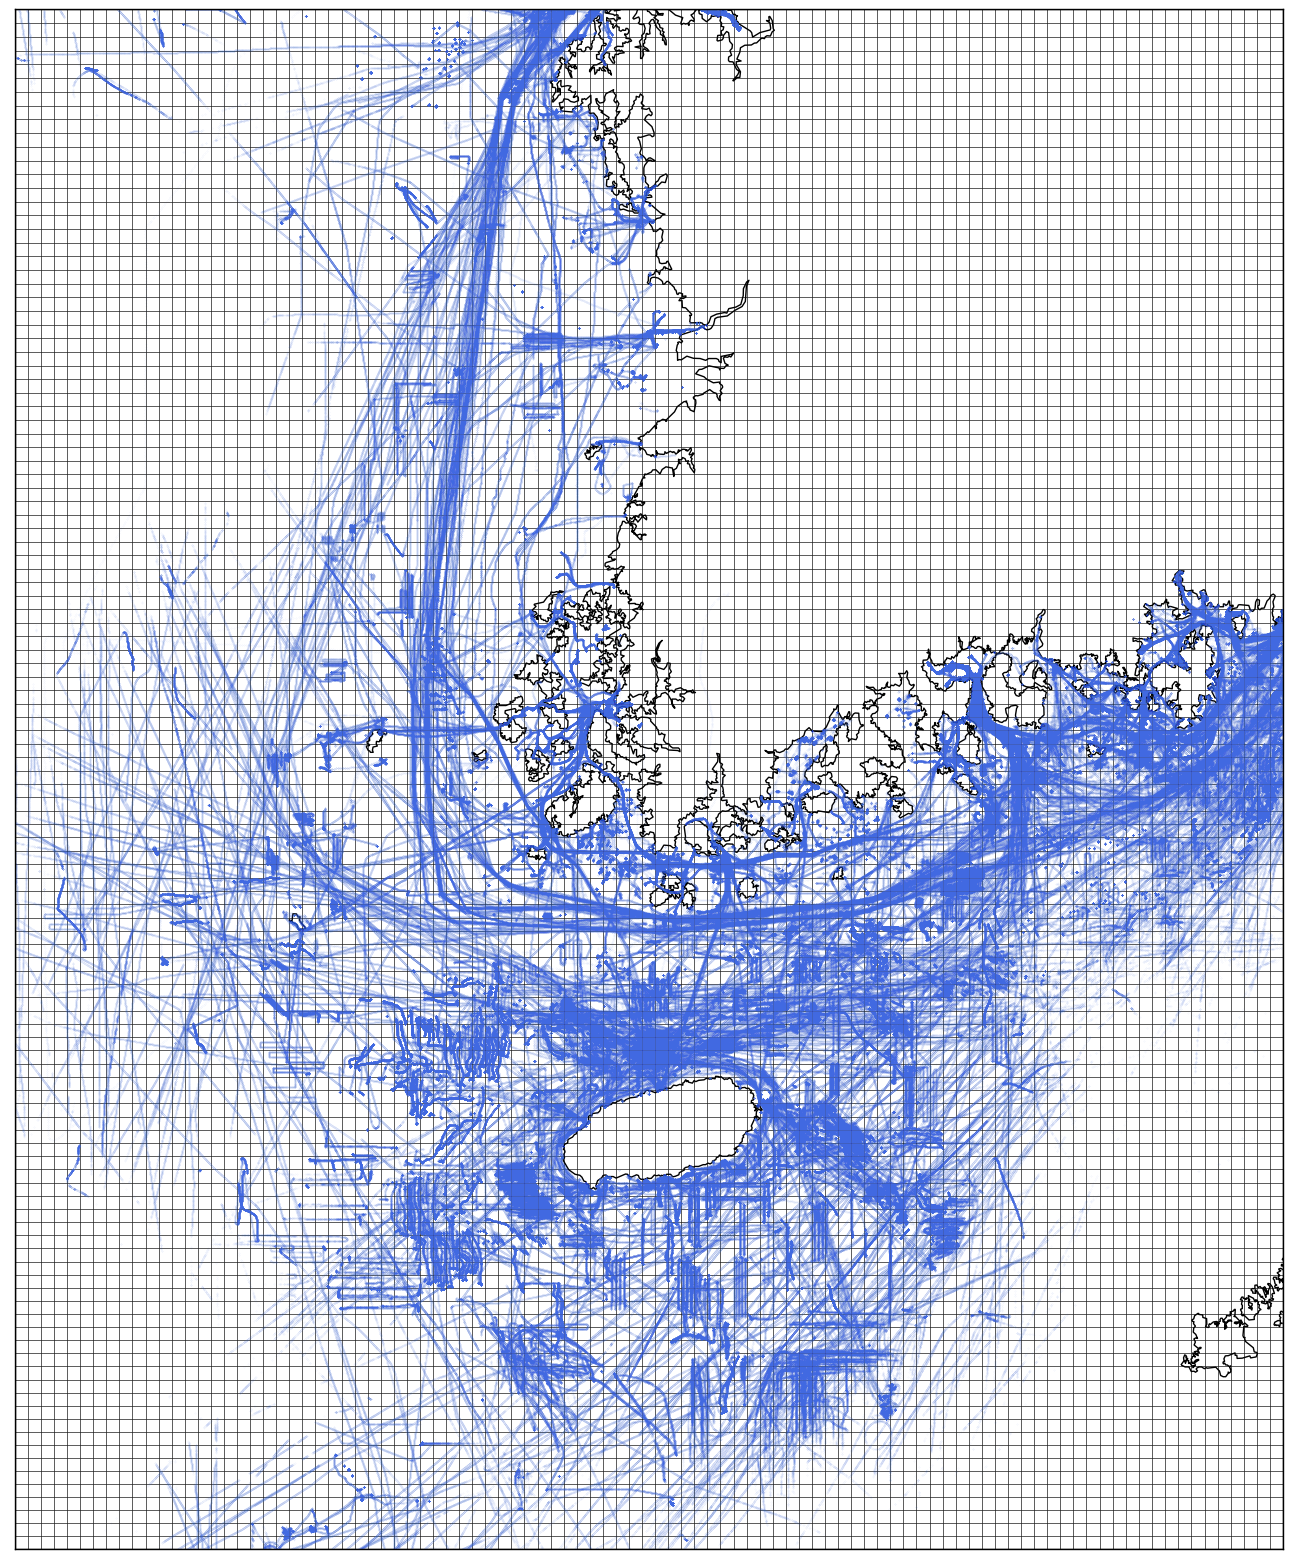

In [9]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%d,%d)'%(ilon-1, ilat-1)
        grid_map[key] = p

print('Draw AIS data')
ais_lons = ais.경도.tolist()
ais_lats = ais.위도.tolist()

print('Draw Graduation')
ais_lons, ais_lats = m(ais_lons, ais_lats)
plt.plot(ais_lons, ais_lats, 'o', c='royalblue', alpha=0.1, markersize=0.2)
plt.show()

In [15]:
mmsis = list(set(ais["MMSI"].tolist()))
ais_dict = {}
progress = []
for i in range(0, len(mmsis)):
    per = int((i/len(mmsis))*100)
    if(per%5 == 0 and per not in progress):
        progress.append(per)
        print('Progress rate: %d/%d'%(per, 100))
        
    ais_dict[mmsis[i]] = ais[ais['MMSI'] == mmsis[i]]
print('Progress rate: %d/%d'%(100, 100))

Progress rate: 0/100
Progress rate: 5/100
Progress rate: 10/100
Progress rate: 15/100
Progress rate: 20/100
Progress rate: 25/100
Progress rate: 30/100
Progress rate: 35/100
Progress rate: 40/100
Progress rate: 45/100
Progress rate: 50/100
Progress rate: 55/100
Progress rate: 60/100
Progress rate: 65/100
Progress rate: 70/100
Progress rate: 75/100
Progress rate: 80/100
Progress rate: 85/100
Progress rate: 90/100
Progress rate: 95/100


In [21]:
current_time = '2020-02-03 12:00:00'
predict_time = '2020-02-03 13:00:00'
selected_pos = []

In [ ]:
# detect ship
current_vessel_position = {}
date_time_current = time.strptime(current_time, '%Y-%m-%d %H:%M:%S')
for mmsi in mmsis:
    for col, ser in ais_dict[mmsi].iterrows():
        mdate = ser['일자']
        mtime = ser['시간']
        datetime_str_obj = "%s %s"%(mdate, mtime)
        date_time_obj = time.strptime(datetime_str_obj, '%Y-%m-%d %H:%M:%S')
        
        if(date_time_current <= date_time_obj):
            current_vessel_position[mmsi] = ser
            break

In [ ]:
current_vessel_position

In [ ]:
def find_grid_key(llist, v):
    result = -1
    for i in range(0, len(llist)-1):
        if llist[i] < v and llist[i+1] >= v:
            result = llist[i]
            break
    return result

In [ ]:
print('Draw Basemap')
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

print('Draw Gridmap')
grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%f,%f)'%(grid_lat[ilat-1], grid_lon[ilon-1])
        grid_map[key] = [p, []]

print('Draw Ships')
for mmsi in mmsis:
    ser = current_vessel_position[mmsi]
    mlon, mlat = m(ser['경도'], ser['위도'])
    plt.plot(mlon, mlat, 'o', c='gold', alpha=1, markersize=3)
            

print('Calculate grid congestion per each')
# 전체 기간
# for lon in ais.경도.tolist():
#     klon = find_grid_key(grid_lon, lon)
#     for lat in ais.위도.tolist():
#         klat = find_grid_key(grid_lat, lat)
#         key = '(%f,%f)'%(klat, klon)
#         grid_map[key][1] += 1

for mmsi in mmsis:
    ser = current_vessel_position[mmsi]
    klat = find_grid_key(grid_lat, ser['위도'])
    klon = find_grid_key(grid_lon, ser['경도'])
    key = '(%f,%f)'%(klat, klon)
    grid_map[key][1].append(mmsi)

print('Draw Graduation')
xt, yt = m(np.arange(base_lon[0], base_lon[1]), np.arange(base_lat[0], base_lat[1]))
plt.xticks(xt, labels = [str(x) for x in np.arange(base_lon[0], base_lon[1])])
plt.yticks(yt, labels = [str(x) for x in np.arange(base_lat[0], base_lat[1])])
           
plt.show()